In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import os
import logging
import matplotlib.ticker as ticker

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')


In [2]:
# Centralized file path config
DATA_DIR = ".\\data"

def load_csv(filename):
    try:
        return pd.read_csv(os.path.join(DATA_DIR, filename))
    except FileNotFoundError:
        logging.error(f"File not found: {filename}")
        return pd.DataFrame()


### LOAD & PREPARE PATIENT RESOURCE

In [3]:
# Load data
patients = load_csv("patients.csv")

In [4]:
patients.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,34a210f9-5ce1-ad63-790f-e404455e3e18,1993-11-11,NaN,999-17-3914,S99951712,X60064394X,Mr.,Alexis664,Alexis664,Heathcote539,...,Forestdale,Massachusetts,Barnstable County,25001.0,2644,41.652054,-70.482730,76578.32,15866.26,71625
1,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,1987-08-02,NaN,999-31-9665,S99995857,X51132243X,Mrs.,Mariel814,Tobi258,Lang846,...,Cambridge,Massachusetts,Middlesex County,25017.0,2472,42.410780,-71.110683,146375.89,544097.84,542941
2,b1f7b5a9-5cf5-6050-b23c-81027f53bdfd,1989-03-05,NaN,999-86-4327,S99989586,X14035271X,Mrs.,Luetta803,Zenobia558,Dickens475,...,Walpole,Massachusetts,Norfolk County,25021.0,2081,42.161844,-71.307871,173374.13,476542.11,886745
3,1f2aa6c9-41bd-aa05-9da3-e557d8949816,1993-02-02,NaN,999-34-4274,S99920797,X55368805X,Mrs.,Kittie678,Sigrid676,Braun514,...,Quincy,Massachusetts,Norfolk County,25021.0,2169,42.303030,-71.017743,76375.47,647647.36,35850
4,80e114d1-013b-b546-7aba-17eb360dde04,1999-10-27,NaN,999-36-2412,S99986563,X34475162X,Ms.,Jin479,Nida800,Ward668,...,Williamsburg,Massachusetts,Hampshire County,NaN,0,42.405203,-72.694316,135954.44,262321.29,149942


In [5]:
#checking no_of_rows & columns
patients.shape

(116, 28)

In [6]:
# checking % of null values for each column
patients.isna().sum()/len(patients)*100

Id                      0.000000
BIRTHDATE               0.000000
DEATHDATE              86.206897
SSN                     0.000000
DRIVERS                 8.620690
PASSPORT               14.655172
PREFIX                 11.206897
FIRST                   0.000000
MIDDLE                 15.517241
LAST                    0.000000
SUFFIX                 97.413793
MAIDEN                 70.689655
MARITAL                25.862069
RACE                    0.000000
ETHNICITY               0.000000
GENDER                  0.000000
BIRTHPLACE              0.000000
ADDRESS                 0.000000
CITY                    0.000000
STATE                   0.000000
COUNTY                  0.000000
FIPS                   27.586207
ZIP                     0.000000
LAT                     0.000000
LON                     0.000000
HEALTHCARE_EXPENSES     0.000000
HEALTHCARE_COVERAGE     0.000000
INCOME                  0.000000
dtype: float64

In [7]:
# check data types of patients_clean
patients.dtypes

Id                      object
BIRTHDATE               object
DEATHDATE               object
SSN                     object
DRIVERS                 object
PASSPORT                object
PREFIX                  object
FIRST                   object
MIDDLE                  object
LAST                    object
SUFFIX                  object
MAIDEN                  object
MARITAL                 object
RACE                    object
ETHNICITY               object
GENDER                  object
BIRTHPLACE              object
ADDRESS                 object
CITY                    object
STATE                   object
COUNTY                  object
FIPS                   float64
ZIP                      int64
LAT                    float64
LON                    float64
HEALTHCARE_EXPENSES    float64
HEALTHCARE_COVERAGE    float64
INCOME                   int64
dtype: object

In [8]:
# Convert the 'BIRTHDATE' column to datetime format, coercing errors to NaT
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'], errors='coerce')

# Get the current date
today = pd.to_datetime("today")

# Create a new 'AGE' column by calculating the age in years
patients['AGE'] = (today - patients['BIRTHDATE']).dt.days // 365

In [9]:
# Rename 'Id' column to 'PATIENT' to prepare for merging
patients.rename(columns={'Id': 'PATIENT'}, inplace=True)


In [10]:
# Select relevant columns from the patient resource for analysis
patients_clean = patients[['PATIENT', 'AGE', 'GENDER', 'RACE', 'ETHNICITY',
                           'STATE', 'ZIP', 'HEALTHCARE_EXPENSES',
                           'HEALTHCARE_COVERAGE', 'INCOME']].copy()


In [11]:
# Check percentage of null values in the selected columns
patients_clean.isna().sum() / len(patients_clean) * 100

PATIENT                0.0
AGE                    0.0
GENDER                 0.0
RACE                   0.0
ETHNICITY              0.0
STATE                  0.0
ZIP                    0.0
HEALTHCARE_EXPENSES    0.0
HEALTHCARE_COVERAGE    0.0
INCOME                 0.0
dtype: float64

In [12]:
# Re-check data types of patients_clean
patients_clean.dtypes

PATIENT                 object
AGE                      int64
GENDER                  object
RACE                    object
ETHNICITY               object
STATE                   object
ZIP                      int64
HEALTHCARE_EXPENSES    float64
HEALTHCARE_COVERAGE    float64
INCOME                   int64
dtype: object

### CHRONIC CONDITION TAGGING

In [13]:
# Load condition resource data
condition = load_csv("conditions.csv")

In [14]:
condition.head()

,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
0,2012-01-05,NaN,34a210f9-5ce1-ad63-790f-e404455e3e18,4a49987e-7f62-22a0-4cf4-34db4b838d73,http://snomed.info/sct,224299000,Received higher education (finding)
1,2012-01-05,NaN,34a210f9-5ce1-ad63-790f-e404455e3e18,4a49987e-7f62-22a0-4cf4-34db4b838d73,http://snomed.info/sct,160903007,Full-time employment (finding)
2,2013-01-10,2019-01-17,34a210f9-5ce1-ad63-790f-e404455e3e18,f7410e81-0416-e57c-07f0-24b9dee39d48,http://snomed.info/sct,314529007,Medication review due (situation)
3,2016-01-14,NaN,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,http://snomed.info/sct,73595000,Stress (finding)
4,2016-01-14,2019-01-17,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,http://snomed.info/sct,706893006,Victim of intimate partner abuse (finding)


In [15]:
#checking no_of_rows & columns
condition.shape

(4428, 7)

In [16]:
# checking % of null values for each column
condition.isna().sum()/len(condition)*100

START           0.00000
STOP           27.03252
PATIENT         0.00000
ENCOUNTER       0.00000
SYSTEM          0.00000
CODE            0.00000
DESCRIPTION     0.00000
dtype: float64

In [17]:
# Re-check data types of patients_clean
condition.dtypes

START          object
STOP           object
PATIENT        object
ENCOUNTER      object
SYSTEM         object
CODE            int64
DESCRIPTION    object
dtype: object

In [18]:
# Convert all text in 'DESCRIPTION' column to lowercase for case-insensitive matching
condition['DESCRIPTION'] = condition['DESCRIPTION'].str.lower()

In [19]:
# List of keywords representing common chronic conditions
# Note: In real-world scenarios, we would map diagnosis codes to a standardized vocabulary like SNOMED CT.
# Here, we directly use known keywords since this is test data with a limited set of unique values.
chronic_keywords = [
    "diabetes", "hyperlipidemia", "hyperglycemia", "metabolic syndrome", 
    "hypertension", "heart failure", "myocardial infarction", 
    "atrial fibrillation", "ischemic heart disease", "asthma", 
    "obstructive sleep apnea", "sleep apnea", "chronic pain", 
    "chronic low back pain", "chronic neck pain", 
    "rheumatoid arthritis", "osteoarthritis", "fibromyalgia", 
    "osteoporosis", "alzheimer", "seizure disorder", 
    "chronic kidney disease", "end-stage renal disease", 
    "proteinuria", "microalbuminuria", "neuropathy", 
    "emphysema", "pulmonary emphysema", 
    "migraine", "retinopathy", "macular edema", 
    "nonproliferative diabetic retinopathy", 
    "proliferative diabetic retinopathy",
    "blindness due to type 2 diabetes", 
    "chronic congestive heart failure", 
    "chronic sinusitis"
]


In [20]:
# Create a boolean column 'IS_CHRONIC' to mark if DESCRIPTION contains any chronic condition keywords
condition['IS_CHRONIC'] = condition['DESCRIPTION'].apply(
    lambda x: any(keyword in x for keyword in chronic_keywords)
)

In [21]:
# Check if 'IS_CHRONIC' column was added
condition.dtypes

START          object
STOP           object
PATIENT        object
ENCOUNTER      object
SYSTEM         object
CODE            int64
DESCRIPTION    object
IS_CHRONIC       bool
dtype: object

In [22]:
# Extract unique patient IDs with chronic conditions and add a flag column 'HAS_CHRONIC'
chronic_patients = condition[condition['IS_CHRONIC']][['PATIENT']].drop_duplicates()
chronic_patients['HAS_CHRONIC'] = 1

In [23]:
# Inspect chronic_patients

chronic_patients.head()

,PATIENT,HAS_CHRONIC
7,34a210f9-5ce1-ad63-790f-e404455e3e18,1
13,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,1
34,b1f7b5a9-5cf5-6050-b23c-81027f53bdfd,1
61,1f2aa6c9-41bd-aa05-9da3-e557d8949816,1
107,80e114d1-013b-b546-7aba-17eb360dde04,1


#### Merge chronic condition flag with patient profile data

In [24]:
patients_profile = patients_clean.merge(chronic_patients, on='PATIENT', how='left')


In [25]:
# Fill missing values with 0 for patients without chronic conditions and convert flag to integer
patients_profile['HAS_CHRONIC'] = patients_profile['HAS_CHRONIC'].fillna(0).astype(int)

In [26]:
#Inspect 
patients_profile.head()

,PATIENT,AGE,GENDER,RACE,ETHNICITY,STATE,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,HAS_CHRONIC
0,34a210f9-5ce1-ad63-790f-e404455e3e18,31,M,white,nonhispanic,Massachusetts,2644,76578.32,15866.26,71625,1
1,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,37,F,white,nonhispanic,Massachusetts,2472,146375.89,544097.84,542941,1
2,b1f7b5a9-5cf5-6050-b23c-81027f53bdfd,36,F,white,nonhispanic,Massachusetts,2081,173374.13,476542.11,886745,1
3,1f2aa6c9-41bd-aa05-9da3-e557d8949816,32,F,white,nonhispanic,Massachusetts,2169,76375.47,647647.36,35850,1
4,80e114d1-013b-b546-7aba-17eb360dde04,25,F,white,nonhispanic,Massachusetts,0,135954.44,262321.29,149942,1


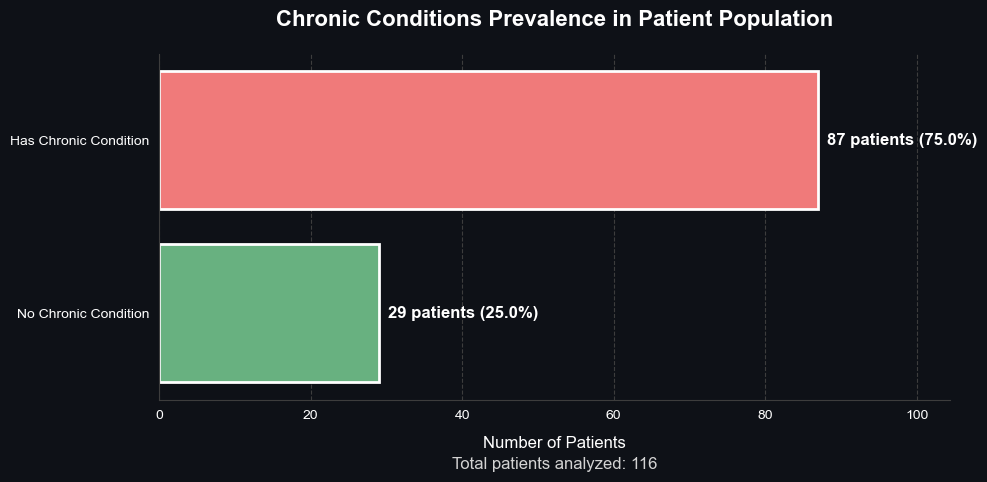

In [27]:
#visualization
sns.set_style("darkgrid", {"axes.facecolor": "#0e1117", "figure.facecolor": "#0e1117"})
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Prepare data
chronic_counts = patients_profile['HAS_CHRONIC'].value_counts().rename(
    {0: 'No Chronic Condition', 1: 'Has Chronic Condition'}
)

# Create a more visually appealing plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x=chronic_counts.values, 
    y=chronic_counts.index, 
    palette=['#ff6b6b', '#5fba7d'],
    edgecolor='white',
    linewidth=2,
    saturation=0.8
)

# Add value labels with percentage
total = chronic_counts.sum()
for i, value in enumerate(chronic_counts.values):
    percentage = 100 * value / total
    ax.text(
        value + total*0.01,  
        i, 
        f'{value:,} patients ({percentage:.1f}%)', 
        va='center', 
        fontweight='bold',
        color='white',
        fontsize=12
    )

# Customize the plot
plt.title(
    'Chronic Conditions Prevalence in Patient Population', 
    fontsize=16, 
    fontweight='bold',
    pad=20
)
plt.xlabel('Number of Patients', fontsize=12, labelpad=10)
plt.ylabel('') 
plt.xlim(0, max(chronic_counts.values) * 1.2) 

# Remove spines and customize grid
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#3d3d3d')
ax.spines['bottom'].set_color('#3d3d3d')
ax.grid(axis='x', color='#3d3d3d', linestyle='--')

# Add annotation for insight
plt.annotate(
    f'Total patients analyzed: {total:,}',
    xy=(0.5, -0.2),
    xycoords='axes fraction',
    ha='center',
    fontsize=12,
    color='lightgray'
)

plt.tight_layout()
plt.show()

**Chronic Condition Summary**

- 87 patients (75%) have at least one chronic condition.
- 29 patients (25%) do not have any chronic conditions.

###  EMERGENCY ROOM (ER) VISIT COST ANALYSIS

In [28]:
# Load encounter resource data
encounters = load_csv("encounters.csv")

In [29]:
# Inspect
encounters.head()

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,4a49987e-7f62-22a0-4cf4-34db4b838d73,2012-01-05T12:24:26Z,2012-01-05T13:06:24Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),136.80,1149.97,0.00,NaN,NaN
1,f7410e81-0416-e57c-07f0-24b9dee39d48,2013-01-10T12:24:26Z,2013-01-10T12:59:24Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),136.80,704.20,0.00,NaN,NaN
2,5f4177ca-c592-bc22-116c-27de8b3b1cb5,2016-01-14T12:24:26Z,2016-01-14T12:59:03Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),136.80,1186.78,0.00,NaN,NaN
3,8226dce4-9bc8-cb09-68d6-0fb376cbf349,2017-09-08T11:24:26Z,2017-09-08T11:39:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,9d989fcf-4ad9-3972-ada3-f275d967781e,7a828299-9a03-3a78-92ad-664a0ba130fc,d31fccc3-1767-390d-966a-22a5156f4219,ambulatory,185345009,Encounter for symptom (procedure),85.55,85.55,0.00,444814009.0,Viral sinusitis (disorder)
4,4a423bf9-cd55-bc73-9ae0-fffaeaf87de0,2019-01-17T12:24:26Z,2019-01-17T13:15:35Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),136.80,1712.02,203.22,NaN,NaN


In [30]:
#checking no_of_rows & columns
encounters.shape

(6621, 15)

In [31]:
# checking % of null values for each column
encounters.isna().sum()/len(encounters)*100

Id                      0.00000
START                   0.00000
STOP                    0.00000
PATIENT                 0.00000
ORGANIZATION            0.00000
PROVIDER                0.00000
PAYER                   0.00000
ENCOUNTERCLASS          0.00000
CODE                    0.00000
DESCRIPTION             0.00000
BASE_ENCOUNTER_COST     0.00000
TOTAL_CLAIM_COST        0.00000
PAYER_COVERAGE          0.00000
REASONCODE             40.12989
REASONDESCRIPTION      40.12989
dtype: float64

In [32]:
#check data types
encounters.dtypes

Id                      object
START                   object
STOP                    object
PATIENT                 object
ORGANIZATION            object
PROVIDER                object
PAYER                   object
ENCOUNTERCLASS          object
CODE                     int64
DESCRIPTION             object
BASE_ENCOUNTER_COST    float64
TOTAL_CLAIM_COST       float64
PAYER_COVERAGE         float64
REASONCODE             float64
REASONDESCRIPTION       object
dtype: object

In [33]:
# Convert the 'START' column to datetime format, handling invalid formats as NaT
encounters['START'] = pd.to_datetime(encounters['START'], errors='coerce')

In [34]:
#re-check data type
encounters.dtypes

Id                                  object
START                  datetime64[ns, UTC]
STOP                                object
PATIENT                             object
ORGANIZATION                        object
PROVIDER                            object
PAYER                               object
ENCOUNTERCLASS                      object
CODE                                 int64
DESCRIPTION                         object
BASE_ENCOUNTER_COST                float64
TOTAL_CLAIM_COST                   float64
PAYER_COVERAGE                     float64
REASONCODE                         float64
REASONDESCRIPTION                   object
dtype: object

In [35]:
# Merge encounters data with patient profiles to bring in demographic and chronic condition info
patient_encounters = encounters.merge(patients_profile, on='PATIENT', how='left')

In [36]:
patient_encounters.head(5)

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,...,AGE,GENDER,RACE,ETHNICITY,STATE,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,HAS_CHRONIC
0,4a49987e-7f62-22a0-4cf4-34db4b838d73,2012-01-05 12:24:26+00:00,2012-01-05T13:06:24Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),...,31,M,white,nonhispanic,Massachusetts,2644,76578.32,15866.26,71625,1
1,f7410e81-0416-e57c-07f0-24b9dee39d48,2013-01-10 12:24:26+00:00,2013-01-10T12:59:24Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),...,31,M,white,nonhispanic,Massachusetts,2644,76578.32,15866.26,71625,1
2,5f4177ca-c592-bc22-116c-27de8b3b1cb5,2016-01-14 12:24:26+00:00,2016-01-14T12:59:03Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),...,31,M,white,nonhispanic,Massachusetts,2644,76578.32,15866.26,71625,1
3,8226dce4-9bc8-cb09-68d6-0fb376cbf349,2017-09-08 11:24:26+00:00,2017-09-08T11:39:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,9d989fcf-4ad9-3972-ada3-f275d967781e,7a828299-9a03-3a78-92ad-664a0ba130fc,d31fccc3-1767-390d-966a-22a5156f4219,ambulatory,185345009,Encounter for symptom (procedure),...,31,M,white,nonhispanic,Massachusetts,2644,76578.32,15866.26,71625,1
4,4a423bf9-cd55-bc73-9ae0-fffaeaf87de0,2019-01-17 12:24:26+00:00,2019-01-17T13:15:35Z,34a210f9-5ce1-ad63-790f-e404455e3e18,104079d4-560e-3eb8-9a48-d495835a3997,d540c8fb-c7b4-3a87-bdc9-55e0daf3f8c2,d31fccc3-1767-390d-966a-22a5156f4219,wellness,162673000,General examination of patient (procedure),...,31,M,white,nonhispanic,Massachusetts,2644,76578.32,15866.26,71625,1


In [37]:
# Filter for emergency room (ER) visits only
er_visits = patient_encounters[
    patient_encounters['ENCOUNTERCLASS'].str.lower() == 'emergency'
]

In [38]:
er_visits[['PATIENT', 'START', 'DESCRIPTION', 'TOTAL_CLAIM_COST', 'HAS_CHRONIC']].head()

,PATIENT,START,DESCRIPTION,TOTAL_CLAIM_COST,HAS_CHRONIC
26,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,2017-08-29 10:07:10+00:00,Emergency room admission (procedure),146.18,1
46,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,2022-05-29 09:19:57+00:00,Obstetric emergency hospital admission (proced...,6110.05,1
58,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,2024-03-24 09:19:57+00:00,Obstetric emergency hospital admission (proced...,1529.72,1
81,b1f7b5a9-5cf5-6050-b23c-81027f53bdfd,2017-11-19 16:04:02+00:00,Obstetric emergency hospital admission (proced...,577.58,1
101,b1f7b5a9-5cf5-6050-b23c-81027f53bdfd,2021-10-24 16:04:02+00:00,Obstetric emergency hospital admission (proced...,577.58,1


In [39]:
# Count the number of ER visits made by patients with and without chronic conditions
er_visits['HAS_CHRONIC'].value_counts()

1    179
0     40
Name: HAS_CHRONIC, dtype: int64

In [40]:
# Calculate total ER cost per patient, grouped by chronic condition status
er_cost_per_patient = er_visits.groupby(['PATIENT', 'HAS_CHRONIC'])['TOTAL_CLAIM_COST'] \
                               .sum().reset_index()

In [41]:
# Compute average ER cost for patients with and without chronic conditions
avg_cost_by_chronic = er_cost_per_patient.groupby('HAS_CHRONIC')['TOTAL_CLAIM_COST'] \
                                         .mean().reset_index()

avg_cost_by_chronic.columns = ['HAS_CHRONIC', 'AVG_ER_COST']

In [42]:
#Do chronic patients cost more in the ER?

for i, row in avg_cost_by_chronic.iterrows():
    group = "Chronic Patients" if row['HAS_CHRONIC'] == 1 else "Non-Chronic Patients"
    print(f"{group}: ${row['AVG_ER_COST']:.2f} average ER cost")

Non-Chronic Patients: $3866.12 average ER cost
Chronic Patients: $12334.37 average ER cost


### Insight : ER Cost Burden — Chronic vs Non-Chronic Patients

On average, chronic condition patients cost over 3× more per ER visit than non-chronic patients.

Chronic: $12,334.37

Non-Chronic: $3,866.12

👉 This indicates a need for improved chronic disease management, follow-ups, or care coordination.

### Visualizing Costliest Encounter Types

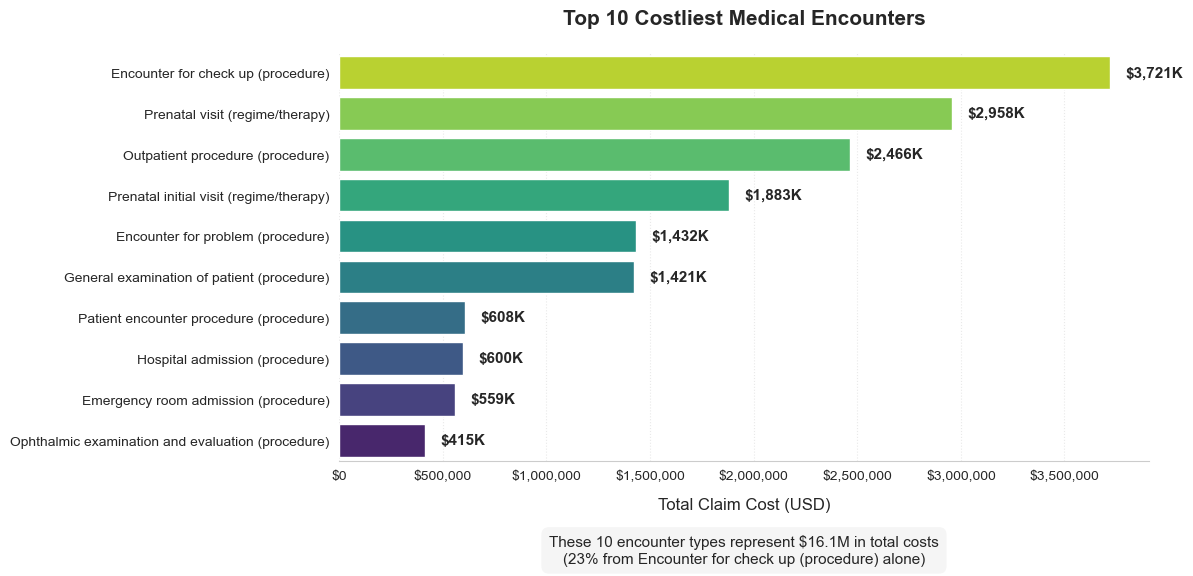

In [43]:
# Set style
sns.set_style("whitegrid", {'grid.color': '#e0e0e0'})
plt.rcParams['axes.titlepad'] = 20

# Data
top_encounters = encounters.groupby('DESCRIPTION')['TOTAL_CLAIM_COST'] \
                          .sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_encounters.values,
    y=top_encounters.index,
    palette='viridis_r',
    saturation=0.85
)

# Title and labels
plt.title("Top 10 Costliest Medical Encounters", 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Total Claim Cost (USD)", fontsize=12, labelpad=10)
plt.ylabel("") 

# Format x-axis as currency
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Dynamic value labels
max_val = top_encounters.values.max()
for i, (desc, cost) in enumerate(zip(top_encounters.index, top_encounters.values)):
    ax.text(
        cost + max_val * 0.02,
        i,
        f'${cost/1000:,.0f}K',
        va='center',
        fontsize=11,
        fontweight='bold'
    )

# Add analysis annotation
total = top_encounters.sum()
plt.annotate(
    f"These 10 encounter types represent ${total/1e6:,.1f}M in total costs\n"
    f"({top_encounters.iloc[0]/total:.0%} from {top_encounters.index[0]} alone)",
    xy=(0.5, -0.25),
    xycoords='axes fraction',
    ha='center',
    fontsize=11,
    bbox=dict(boxstyle='round', fc='#f5f5f5', ec='none', pad=0.5)
)

# Remove spines and adjust grid
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

### Are there high-cost patients or procedures that may be avoidable (repeat ER use)?

In [44]:
# Count ER visits per patient
er_visit_counts = er_visits.groupby('PATIENT').size().reset_index(name='ER_VISIT_COUNT')

#Filter for repeat users (3+ ER visits)
repeat_er_users = er_visit_counts[er_visit_counts['ER_VISIT_COUNT'] >= 3]

repeat_er_users.head()

,PATIENT,ER_VISIT_COUNT
0,00df57ef-f14a-d64f-1363-ea5addcd65a1,3
3,0a5d638e-aeb9-5daf-ccfe-3fa63849546c,3
6,0f513626-2d46-1178-db47-491008ec76a3,11
7,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,3
12,1871d3bf-072c-aabf-d872-d5355a5196be,3


### COST OF REPEAT ER USERS

In [45]:
# Merge with er_visits to get cost
repeat_er_data = er_visits.merge(repeat_er_users, on='PATIENT', how='inner')

# Total cost from repeat users
total_repeat_er_cost = repeat_er_data['TOTAL_CLAIM_COST'].sum()

# Total ER cost overall
total_er_cost = er_visits['TOTAL_CLAIM_COST'].sum()

# % of cost from repeat users
repeat_cost_percent = (total_repeat_er_cost / total_er_cost) * 100

In [46]:
print(f"Total ER cost from repeat users: ${total_repeat_er_cost:,.2f}")
print(f"This represents {repeat_cost_percent:.2f}% of all ER spending.")

Total ER cost from repeat users: $493,709.99
This represents 57.79% of all ER spending.


### Insight: ER Cost Burden — Repeat Users

Only 25 patients had 3 or more ER visits, yet they accounted for $493,709.99, representing 57.79% of all ER spending.

👉 This highlights that a small group of frequent ER users drive the majority of ER costs, indicating a need for targeted interventions, better care coordination, or alternative care pathways for high-utilization patients.

### CARE GAP: DIABETES &  HbA1c TEST COMPLIANCE

In [47]:
#Load condition resource
conditions = load_csv("conditions.csv")

In [48]:
# Convert all condition descriptions to lowercase for case-insensitive matching
conditions['DESCRIPTION'] = conditions['DESCRIPTION'].str.lower()

In [49]:
# Here, we directly use known keywords since this is test data with a limited set of unique values.
# In real-time, diagnosis codes like ICD-10 or SNOMED CT would be preferred for standardization.

# Define keywords that indicate a patient has diabetes
diabetes_keywords = ['diabetes mellitus', 'type 2 diabetes', 'type ii diabetes']


In [50]:
# Create a new boolean column 'IS_DIABETIC' to mark if the patient's condition description contains any diabetes keyword
conditions['IS_DIABETIC'] = conditions['DESCRIPTION'].apply(
    lambda x: any(keyword in x for keyword in diabetes_keywords)
)

# Get unique patient IDs who have diabetes based on the conditions dataset
diabetes_patients = conditions[conditions['IS_DIABETIC']]['PATIENT'].drop_duplicates()
print(f"Total diabetic patients: {len(diabetes_patients)}")

Total diabetic patients: 18


#### OBSERVATION RESOURCE

In [51]:
# Load observations data, which presumably contains lab test results or other medical observations
observations = load_csv("observations.csv")

In [52]:
observations.head()

,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2016-01-14T12:24:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,vital-signs,8302-2,Body Height,181.2,cm,numeric
1,2016-01-14T12:24:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},numeric
2,2016-01-14T12:24:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,vital-signs,29463-7,Body Weight,73.4,kg,numeric
3,2016-01-14T12:24:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,vital-signs,39156-5,Body mass index (BMI) [Ratio],22.3,kg/m2,numeric
4,2016-01-14T12:24:26Z,34a210f9-5ce1-ad63-790f-e404455e3e18,5f4177ca-c592-bc22-116c-27de8b3b1cb5,vital-signs,8462-4,Diastolic Blood Pressure,68.0,mm[Hg],numeric


In [53]:
#checking no_of_rows & columns
observations.shape

(96124, 9)

In [54]:
# checking % of null values for each column
observations.isna().sum()/len(observations)*100

DATE            0.000000
PATIENT         0.000000
ENCOUNTER       3.245807
CATEGORY        3.245807
CODE            0.000000
DESCRIPTION     0.000000
VALUE           0.000000
UNITS          27.461404
TYPE            0.000000
dtype: float64

In [55]:
#check datatypes
observations.dtypes

DATE           object
PATIENT        object
ENCOUNTER      object
CATEGORY       object
CODE           object
DESCRIPTION    object
VALUE          object
UNITS          object
TYPE           object
dtype: object

In [56]:
# Ensure the DESCRIPTION is lowercase for matching
observations['DESCRIPTION'] = observations['DESCRIPTION'].str.lower()

# Flag patients who had any HbA1c test
hba1c_patients = observations[observations['DESCRIPTION'].str.contains('a1c')]['PATIENT'].drop_duplicates()
diabetic_without_hba1c = set(diabetes_patients) - set(hba1c_patients)


In [57]:
# Intersect only diabetic patients who had HbA1c test
diabetics_with_hba1c = set(diabetes_patients) & set(hba1c_patients)

# Diabetics missing HbA1c test
diabetic_without_hba1c = set(diabetes_patients) - set(hba1c_patients)

# Print correct numbers
print(f"Total diabetic patients: {len(diabetes_patients)}")
print(f"Diabetic patients with HbA1c test: {len(diabetics_with_hba1c)}")
print(f"Diabetic patients missing HbA1c test: {len(diabetic_without_hba1c)}")

# Calculate correct compliance
compliance_rate = len(diabetics_with_hba1c) / len(diabetes_patients) * 100
gap_rate = 100 - compliance_rate

print(f"HbA1c Compliance Rate: {compliance_rate:.2f}%")
print(f"Care Gap: {gap_rate:.2f}%")


Total diabetic patients: 18
Diabetic patients with HbA1c test: 17
Diabetic patients missing HbA1c test: 1
HbA1c Compliance Rate: 94.44%
Care Gap: 5.56%


### INSIGHT

👉 Identified that 94.4% of diabetic patients received the recommended HbA1c testing, leaving a small but measurable care gap (5.6%). While the absolute number is low, if scaled across larger populations, this could represent missed opportunities for timely chronic care management and early intervention.

### ALLERGIES & MEDICATION RESOURCE

In [58]:
#Load allergies resource
allergies = load_csv("allergies.csv")

In [59]:
allergies.head(5)

,START,STOP,PATIENT,ENCOUNTER,CODE,SYSTEM,DESCRIPTION,TYPE,CATEGORY,REACTION1,DESCRIPTION1,SEVERITY1,REACTION2,DESCRIPTION2,SEVERITY2
0,1994-05-14,NaN,64a0ba30-3b8a-2c31-851b-1102c0c7f9f7,7f3404b7-fea4-0af0-be82-8272315f5d02,609328004,SNOMED-CT,Allergic disposition (finding),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-10-06,NaN,3061298e-7645-88b5-5ec8-35026a6abaf1,7d04a999-ab6e-40d9-b1c6-86094fb14e23,609328004,SNOMED-CT,Allergic disposition (finding),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-10-06,NaN,3061298e-7645-88b5-5ec8-35026a6abaf1,7d04a999-ab6e-40d9-b1c6-86094fb14e23,288328004,SNOMED-CT,Bee venom (substance),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-10-06,NaN,3061298e-7645-88b5-5ec8-35026a6abaf1,7d04a999-ab6e-40d9-b1c6-86094fb14e23,84489001,SNOMED-CT,Mold (organism),allergy,environment,76067001.0,Sneezing (finding),MILD,56018004.0,Wheezing (finding),MILD
4,2004-10-06,NaN,3061298e-7645-88b5-5ec8-35026a6abaf1,7d04a999-ab6e-40d9-b1c6-86094fb14e23,260147004,SNOMED-CT,House dust mite (organism),allergy,environment,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
print(allergies.isna().sum()/len(allergies)*100)
print('---------DATA TYPE------')
print(allergies.dtypes)

START             0.0
STOP            100.0
PATIENT           0.0
ENCOUNTER         0.0
CODE              0.0
SYSTEM            0.0
DESCRIPTION       0.0
TYPE              0.0
CATEGORY          0.0
REACTION1        55.0
DESCRIPTION1     55.0
SEVERITY1        55.0
REACTION2        73.0
DESCRIPTION2     73.0
SEVERITY2        73.0
dtype: float64
---------DATA TYPE------
START            object
STOP            float64
PATIENT          object
ENCOUNTER        object
CODE              int64
SYSTEM           object
DESCRIPTION      object
TYPE             object
CATEGORY         object
REACTION1       float64
DESCRIPTION1     object
SEVERITY1        object
REACTION2       float64
DESCRIPTION2     object
SEVERITY2        object
dtype: object


In [61]:
#Load allergies resource
medications = load_csv("medications.csv")

In [62]:
medications.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2014-08-27T07:10:43Z,2015-08-26T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,23c14b40-6a1e-a422-e0a2-751e44fb4ca7,807283,Mirena 52 MG Intrauterine System,10.00,0.00,12,120.00,NaN,NaN
1,2019-08-05T21:57:17Z,2020-07-30T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,70d9e778-4ec3-edc8-423e-c60189b62884,757594,Jolivette 28 Day Pack,229.32,0.00,12,2751.84,NaN,NaN
2,2020-07-30T21:57:17Z,2021-07-25T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,4aa5f00f-829c-fbb8-2b9e-6139e49e6151,757594,Jolivette 28 Day Pack,764.40,0.00,12,9172.80,NaN,NaN
3,2021-10-24T10:41:12Z,NaN,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,3b81c72e-3c1b-6259-21f5-fa49a4eaeb7f,310325,ferrous sulfate 325 MG Oral Tablet,0.15,0.15,43,6.45,NaN,NaN
4,2021-11-07T12:23:13Z,2021-11-07T12:23:13Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,0ffa9f68-d03e-7795-6aba-30a28d7b2378,1535362,sodium fluoride 0.0272 MG/MG Oral Gel,129.94,129.94,1,129.94,66383009.0,Gingivitis (disorder)


In [63]:
allergies['DESCRIPTION'] = allergies['DESCRIPTION'].str.lower()
medications['DESCRIPTION'] = medications['DESCRIPTION'].str.lower()

In [64]:
# Group allergies per patient
patient_allergies = allergies.groupby('PATIENT')['DESCRIPTION'].apply(list).reset_index()
patient_allergies.columns = ['PATIENT', 'ALLERGIES']

In [65]:
patient_allergies.head()

,PATIENT,ALLERGIES
0,0a5d638e-aeb9-5daf-ccfe-3fa63849546c,"[allergic disposition (finding), bee venom (su..."
1,0f513626-2d46-1178-db47-491008ec76a3,"[allergic disposition (finding), mold (organis..."
2,1145df21-dfa3-c969-48b8-656ee8521676,"[allergic disposition (finding), mold (organis..."
3,21b06346-d3a6-7426-f4c4-88f2efb60bed,"[allergic disposition (finding), penicillin v]"
4,2da6a59b-d1be-b5a2-5e70-48c7db89a7c0,"[allergic disposition (finding), bee venom (su..."


In [66]:
# Merge medications with allergy data

# Merge on PATIENT
meds_with_allergies = medications.merge(patient_allergies,on='PATIENT', how='left')

In [67]:
meds_with_allergies.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION,ALLERGIES
0,2014-08-27T07:10:43Z,2015-08-26T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,23c14b40-6a1e-a422-e0a2-751e44fb4ca7,807283,mirena 52 mg intrauterine system,10.00,0.00,12,120.00,NaN,NaN,NaN
1,2019-08-05T21:57:17Z,2020-07-30T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,70d9e778-4ec3-edc8-423e-c60189b62884,757594,jolivette 28 day pack,229.32,0.00,12,2751.84,NaN,NaN,NaN
2,2020-07-30T21:57:17Z,2021-07-25T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,4aa5f00f-829c-fbb8-2b9e-6139e49e6151,757594,jolivette 28 day pack,764.40,0.00,12,9172.80,NaN,NaN,NaN
3,2021-10-24T10:41:12Z,NaN,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,3b81c72e-3c1b-6259-21f5-fa49a4eaeb7f,310325,ferrous sulfate 325 mg oral tablet,0.15,0.15,43,6.45,NaN,NaN,NaN
4,2021-11-07T12:23:13Z,2021-11-07T12:23:13Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,0ffa9f68-d03e-7795-6aba-30a28d7b2378,1535362,sodium fluoride 0.0272 mg/mg oral gel,129.94,129.94,1,129.94,66383009.0,Gingivitis (disorder),NaN


In [68]:
# Fill NaN for patients with no recorded allergies
meds_with_allergies['ALLERGIES'] = meds_with_allergies['ALLERGIES'].fillna('').apply(lambda x: x if isinstance(x, list) else [])

In [69]:
meds_with_allergies.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION,ALLERGIES
0,2014-08-27T07:10:43Z,2015-08-26T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,23c14b40-6a1e-a422-e0a2-751e44fb4ca7,807283,mirena 52 mg intrauterine system,10.00,0.00,12,120.00,NaN,NaN,[]
1,2019-08-05T21:57:17Z,2020-07-30T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,70d9e778-4ec3-edc8-423e-c60189b62884,757594,jolivette 28 day pack,229.32,0.00,12,2751.84,NaN,NaN,[]
2,2020-07-30T21:57:17Z,2021-07-25T21:57:17Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,4aa5f00f-829c-fbb8-2b9e-6139e49e6151,757594,jolivette 28 day pack,764.40,0.00,12,9172.80,NaN,NaN,[]
3,2021-10-24T10:41:12Z,NaN,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,3b81c72e-3c1b-6259-21f5-fa49a4eaeb7f,310325,ferrous sulfate 325 mg oral tablet,0.15,0.15,43,6.45,NaN,NaN,[]
4,2021-11-07T12:23:13Z,2021-11-07T12:23:13Z,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,b046940f-1664-3047-bca7-dfa76be352a4,0ffa9f68-d03e-7795-6aba-30a28d7b2378,1535362,sodium fluoride 0.0272 mg/mg oral gel,129.94,129.94,1,129.94,66383009.0,Gingivitis (disorder),[]


In [70]:
def is_conflict(med_name, allergy_list):
    return any(allergy in med_name for allergy in allergy_list)

meds_with_allergies['ALLERGY_CONFLICT'] = meds_with_allergies.apply(
    lambda row: is_conflict(row['DESCRIPTION'], row['ALLERGIES']),
    axis=1
)
# Filter only conflict rows
conflicts = meds_with_allergies[meds_with_allergies['ALLERGY_CONFLICT'] == True]
print(f"Total allergy-medication conflicts found: {len(conflicts)}")

num_allergy_patients = allergies['PATIENT'].nunique()
print(f"Patients with allergies: {num_allergy_patients}")

Total allergy-medication conflicts found: 0
Patients with allergies: 18


### INSIGHT
No medication-allergy conflicts were identified across 18 patients with documented allergies.

In [71]:
# Get top 10 allergy substances
top_allergies = allergies['DESCRIPTION'].value_counts().head(10).reset_index()
top_allergies.columns = ['Substance', 'Reported Cases']

# Display title
display(Markdown("### Top 10 Reported Allergy Substances"))

# Styled table with left-aligned headers and cells
display(
    top_allergies.style.set_properties(**{
        'text-align': 'left',
        'background-color': '#f9f9f9',
        'color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'),
                                     ('background-color', '#f2f2f2'),
                                     ('font-weight', 'bold')]}
    ]).format({'Reported Cases': '{:,.0f}'})
)


### Top 10 Reported Allergy Substances

,Substance,Reported Cases
0,allergic disposition (finding),18
1,mold (organism),12
2,grass pollen (substance),9
3,animal dander (substance),9
4,tree pollen (substance),8
5,eggs (edible) (substance),7
6,house dust mite (organism),7
7,bee venom (substance),6
8,tree nut (substance),5
9,aspirin,3


In [72]:
# Get top 15 meds and turn into a DataFrame
top_meds = medications['DESCRIPTION'].value_counts().head(15).reset_index()
top_meds.columns = ['Medication', 'Prescriptions']

# Display title
display(Markdown("### Top 15 Prescribed Medications"))

# Styled table
display(
    top_meds.style.set_properties(**{
        'text-align': 'left',
        'background-color': '#f9f9f9',
        'color': '#333'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'),
                                     ('background-color', '#f2f2f2'),
                                     ('font-weight', 'bold')]}
    ]).format({'Prescriptions': '{:,.0f}'})
)


### Top 15 Prescribed Medications

,Medication,Prescriptions
0,insulin isophane human 70 unt/ml / insulin regular human 30 unt/ml injectable suspension [humulin],609
1,lisinopril 10 mg oral tablet,473
2,1 ml epoetin alfa 4000 unt/ml injection [epogen],461
3,sodium fluoride 0.0272 mg/mg oral gel,356
4,hydrochlorothiazide 25 mg oral tablet,316
5,24 hr metformin hydrochloride 500 mg extended release oral tablet,288
6,amlodipine 2.5 mg oral tablet,284
7,simvastatin 10 mg oral tablet,189
8,10 ml furosemide 10 mg/ml injection,152
9,tropicamide 5 mg/ml ophthalmic solution,126


### Medication Adherence to Treatment Plans

In [73]:
#Load allergies resource
careplans = load_csv("careplans.csv")

In [74]:
careplans.head()

,Id,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,REASONCODE,REASONDESCRIPTION
0,06b1424d-83f9-229a-024c-bd9c5fa45144,2019-01-17,NaN,34a210f9-5ce1-ad63-790f-e404455e3e18,4a423bf9-cd55-bc73-9ae0-fffaeaf87de0,735985000,Diabetes self management plan (record artifact),714628002.0,Prediabetes (finding)
1,7da083d4-46b9-b81d-6df7-786ec118335a,1998-08-16,NaN,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,dfa86a2b-49cd-6ea0-fd02-047203ffc637,718361005,Weight management program (regime/therapy),NaN,NaN
2,e6431675-03c2-3eff-0ce7-8bae8c053b4b,2017-08-29,2017-10-22,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,7336c92d-a3a7-c70e-cc5d-3346a9d30311,47387005,Head injury rehabilitation (regime/therapy),110030002.0,Concussion injury of brain (disorder)
3,bbd701bd-8f55-426c-2c09-b79920d0be3a,2021-10-10,2022-05-29,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,d07d0c71-6b5a-b719-ff4c-4d6132a685ee,134435003,Routine antenatal care (regime/therapy),NaN,NaN
4,1f14f756-edcd-7040-e183-385ba6393c07,2021-10-17,NaN,0fe22cec-1a19-99da-b67f-7ce364c4cf3e,3388cc3d-45c8-f52d-4185-fa5a593d1be3,735985000,Diabetes self management plan (record artifact),714628002.0,Prediabetes (finding)


In [75]:
list(careplans.columns)

['Id',
 'START',
 'STOP',
 'PATIENT',
 'ENCOUNTER',
 'CODE',
 'DESCRIPTION',
 'REASONCODE',
 'REASONDESCRIPTION']

In [76]:
careplans.isna().mean() * 100

Id                    0.000000
START                 0.000000
STOP                 50.114416
PATIENT               0.000000
ENCOUNTER             0.000000
CODE                  0.000000
DESCRIPTION           0.000000
REASONCODE           40.503432
REASONDESCRIPTION    40.503432
dtype: float64

In [77]:
careplans['DESCRIPTION'] = careplans['DESCRIPTION'].str.lower()

# Flag chronic care plans
careplans['IS_CHRONIC_PLAN'] = careplans['DESCRIPTION'].apply(
    lambda x: any(keyword in x for keyword in chronic_keywords)
)

# Extract patients with chronic care plans
chronic_plan_patients = careplans[careplans['IS_CHRONIC_PLAN']]['PATIENT'].drop_duplicates()
print(f"Patients with chronic care plans: {len(chronic_plan_patients)}")

Patients with chronic care plans: 77


In [78]:
medications['DESCRIPTION'] = medications['DESCRIPTION'].str.lower()

# Match meds for chronic conditions
chronic_meds_keywords = [
    'insulin', 'metformin', 'statin',     # diabetes/lipids
    'lisinopril', 'amlodipine', 'losartan', 'hydrochlorothiazide',  # hypertension
    'inhaler', 'albuterol', 'budesonide',  # asthma/copd
    'donepezil', 'memantine',              # dementia
    'furosemide', 'carvedilol',            # heart failure
]

medications['IS_CHRONIC_MED'] = medications['DESCRIPTION'].apply(
    lambda x: any(keyword in x for keyword in chronic_meds_keywords)
)

chronic_med_patients = medications[medications['IS_CHRONIC_MED']]['PATIENT'].drop_duplicates()
print(f"Patients who received chronic meds: {len(chronic_med_patients)}")

Patients who received chronic meds: 60


In [79]:
# Only check meds for those 77 chronic care plan patients
chronic_meds_given = set(chronic_plan_patients) & set(chronic_med_patients)
non_adherent_patients = set(chronic_plan_patients) - set(chronic_med_patients)

print(f"Patients with chronic care plans: {len(chronic_plan_patients)}")
print(f"Patients who received chronic meds: {len(chronic_meds_given)}")
print(f"Patients with plans but no meds: {len(non_adherent_patients)}")


Patients with chronic care plans: 77
Patients who received chronic meds: 58
Patients with plans but no meds: 19


### INSIGHT

👉 25% of patients with chronic care plans (19 out of 77) did not receive any related medications, indicating a measurable care coordination or adherence gap.